In [ ]:
import pandas as pd

try:
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv("../Dataset/pre_processed_dataset.csv")
    
    print(" Dataset loaded successfully.")
    
    # Display the first 5 rows of the DataFrame
    display(df.head())

except FileNotFoundError:
    print("Error: 'pre_processed_dataset.csv' not found.")
    print("Please make sure the file is in the same directory as your notebook or has been uploaded.")

✅ Dataset loaded successfully.


,Patient_ID,Age,Sex,Family_History,HTT_CAG_Repeat_Length,Age_of_Onset,Motor_Score,Cognitive_Score,Chorea_Score,Functional_Capacity_Score,Gene/Factor,Function,Effect,Category,Disease_Stage,Disease_Duration
0,0,69,1,0,48,55,54,37,10.0,35,1,1,3,1,3,14
1,1,80,0,0,38,78,0,94,0.0,98,1,1,3,1,1,2
2,2,62,0,1,44,62,22,86,10.0,62,1,1,3,1,1,0
3,3,80,0,1,35,80,0,93,0.0,96,2,0,2,0,2,0
4,4,67,1,1,48,57,35,66,10.0,66,1,1,3,1,1,10


Loading preprocessed data from '../Dataset/pre_processed_dataset.csv'...
Files loaded successfully.

Data split into:
39014 training samples (80%)
9754 testing samples (20%)

Running GridSearchCV to find the best MLP parameters...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Grid search and training complete.

Best parameters found: {'classifier__activation': 'tanh', 'classifier__alpha': 0.01, 'classifier__hidden_layer_sizes': (50, 25)}
Best cross-validation accuracy: 0.8389

--- FULL TEST SET RESULTS (Tuned MLP Model) ---
--- FINAL MODEL ACCURACY ON TEST SET: 0.8437 ---


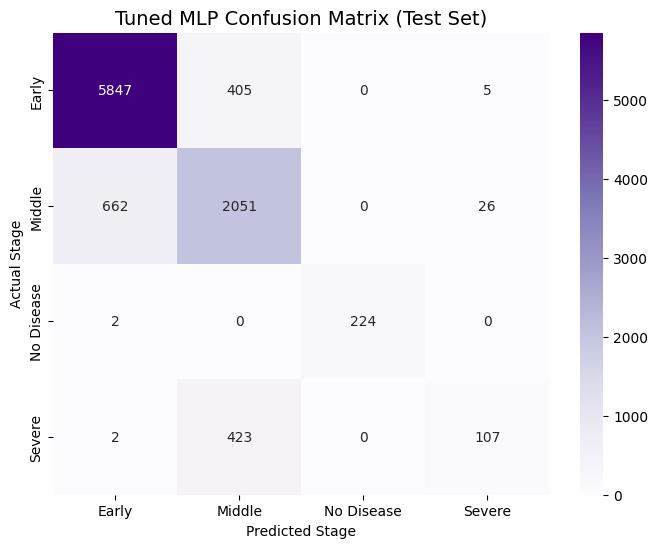


Classification Report (Test Set):
              precision    recall  f1-score   support

       Early       0.90      0.93      0.92      6257
      Middle       0.71      0.75      0.73      2739
  No Disease       1.00      0.99      1.00       226
      Severe       0.78      0.20      0.32       532

    accuracy                           0.84      9754
   macro avg       0.85      0.72      0.74      9754
weighted avg       0.84      0.84      0.83      9754

--------------------------------------------------
Generating ROC/AUC Curve for the Test Set...


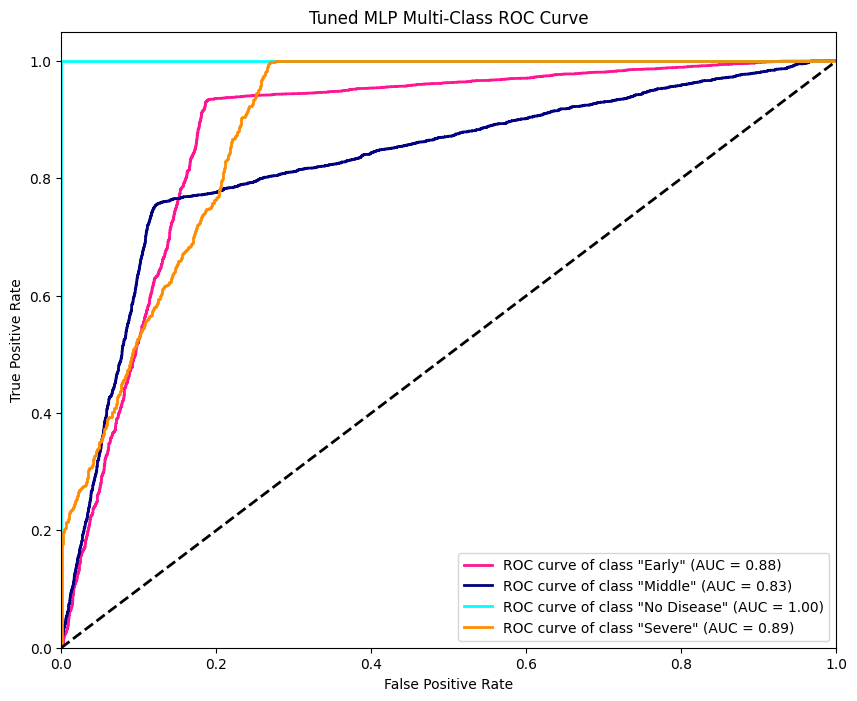


--- Evaluation Complete ---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

# --- 1. Load Data ---
PROCESSED_CLEAN_FILE = "../Dataset/pre_processed_dataset.csv"
RAW_DATA_FILE = "../Dataset/hd_dataset.csv"

print(f"Loading preprocessed data from '{PROCESSED_CLEAN_FILE}'...")
df_processed = pd.read_csv(PROCESSED_CLEAN_FILE)
raw_df = pd.read_csv(RAW_DATA_FILE)
print("Files loaded successfully.")

# --- 2. Prepare Data ---
target_column = 'Disease_Stage'
X = df_processed.drop(target_column, axis=1)
y = df_processed[target_column]

# Get class names for plots
target_le = LabelEncoder()
target_le.fit(raw_df['Disease_Stage'])
class_names = target_le.classes_

# --- 3. Split Data (80% Train, 20% Test) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nData split into:")
print(f"{len(X_train)} training samples (80%)")
print(f"{len(X_test)} testing samples (20%)")

# --- 4. Create the MLP Pipeline ---
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', MLPClassifier(random_state=42, 
                                 max_iter=500,          
                                 early_stopping=True,   
                                 n_iter_no_change=10,   
                                 validation_fraction=0.1 
                                )) 
])

# --- 5. Define the Parameter Grid for MLP ---
param_grid = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (50, 25)],
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__activation': ['relu', 'tanh']
}

# --- 6. Create and Run the Grid Search ---
search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=3, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=1  
)

print("\nRunning GridSearchCV to find the best MLP parameters...")
search.fit(X_train, y_train)
print("Grid search and training complete.")

# --- 7. Show Best Parameters Found ---
print(f"\nBest parameters found: {search.best_params_}")
print(f"Best cross-validation accuracy: {search.best_score_:.4f}")

# -------------------------------------------------------------------
# --- 8. FINAL EVALUATION ON TEST SET ---
# -------------------------------------------------------------------
print("\n--- FULL TEST SET RESULTS (Tuned MLP Model) ---")
# Use the best model found by GridSearchCV ('search') to predict
y_pred_test = search.predict(X_test)
y_proba_test = search.predict_proba(X_test)

accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"--- FINAL MODEL ACCURACY ON TEST SET: {accuracy_test:.4f} ---")

# --- Confusion Matrix ---
cm_test = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Purples', xticklabels=class_names, yticklabels=class_names)
plt.title('Tuned MLP Confusion Matrix (Test Set)', fontsize=14)
plt.ylabel('Actual Stage')
plt.xlabel('Predicted Stage')
plt.show()

# --- Classification Report ---
print("\nClassification Report (Test Set):")
report = classification_report(y_test, y_pred_test, target_names=class_names)
print(report)
print("-" * 50)

# --- Multi-Class ROC/AUC Curve ---
print("Generating ROC/AUC Curve for the Test Set...")
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_proba_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['deeppink', 'navy', 'aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class "{class_names[i]}" (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Tuned MLP Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.show()

print("\n--- Evaluation Complete ---")